**@Dieine Bernieri Schiavon<p>
UFCSPA - Universidade Federal de Ciências da Saúde de Porto Alegre<p>
Informática Biomédica <p>
dieineb@ufcspa.edu.br** <p>
https://github.com/dieineb <p>
**16/09/2022**

# Treinando uma Rede Neural Convolucional do zero em um pequeno conjunto de dados
Ter que treinar um modelo de classificação de imagem usando muito poucos dados é uma situação comum, que você provavelmente encontrará na prática se fizer visão computacional em um contexto profissional. Algumas “poucas” amostras podem significar de algumas centenas a algumas dezenas de milhares de imagens. Como exemplo prático, vamos nos concentrar na classificação
imagens como cães ou gatos, em um conjunto de dados contendo 4.000 fotos de cães e gatos (2.000 gatos, 2.000 cães). Usaremos 2.000 fotos para treinamento – 1.000 para validação e 2.000 para teste. Usaremos aqui uma amostra balanceada, pois temos o mesmo número de amostras de cats and dogs.

# Baixando os dados
O conjunto de dados Dogs vs. Cats que você usará não é fornecido com o Keras. Ele foi disponibilizado pela Kaggle como parte de uma competição de visão computacional no final de 2013. Você pode baixar o conjunto de dados original em www.kaggle.com/c/dogs-vs-cats/data (você precisará criar uma conta Kaggle se ainda não tiver uma é bom criar agora) pois será necessário aceitar um termo para baixar o dataset. Não é necessário baixar tudo, baixe apenas o arquivo Zip Train porque vai ter 25.000 imagens. Após descompactar salve o arquivo train como kaggle_original_data 
  
 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import keras as ke
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import os, shutil, pathlib

In [4]:
original_dir = pathlib.Path('/content/gdrive/MyDrive/Model/kaggle_original_data') # Caminho para o diretório onde o conjunto de dados original foi descompactado
new_base_dir = pathlib.Path('/content/gdrive/MyDrive/Model/cats_and_dogs_small') # Diretório em que será armazenado o conjunto de dados menor

def make_subset(subset_name, start_index, end_index): 
 for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"

               for i in range(start_index, end_index)]
    for fname in fnames:
        shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000) #Cria  o subconjunto de treinamento onde serão armazenadas as primeiras 1000 imagens de cada categoria
make_subset("validation", start_index=1000, end_index=1500) # Cria o subconjuto validação com as próximas 500 imagens de cada categoria
make_subset("test", start_index=1500, end_index=2500) # Cria o subconjunto teste com as próximas 1000 imagens de cada categoria

# Construindo o modelo

In [5]:
from tensorflow import keras 
from tensorflow.keras import layers

In [6]:
inputs = keras.Input(shape=(180, 180, 3)) # Input imagem RGB (Red, Gree, and Blue) =  3 canais - size 180 x 180 
x = layers.Rescaling(1./255)(inputs) # Normalização  Re-escala entradas para o intervalo [0, 1] dividindo por 255

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Classificação binária 1 única saída
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary() # Verifica a arquitetura da rede

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

# Configurando o modelo para treinamento

In [7]:
model.compile(loss="binary_crossentropy",
 optimizer="adam",  # Por default learning_rate = 0.001
 metrics=["accuracy"])

# Pré-processamento dos dados

Os dados devem ser formatados em tensores de ponto flutuante pré-processados ​​adequadamente antes de serem alimentados no modelo. Atualmente, os dados ficam em uma unidade como Arquivos JPEG, portanto, as etapas para colocá-lo no modelo são aproximadamente as seguintes:<p>
1 Leia os arquivos de imagem.<p>
2 Decodifique o conteúdo JPEG em grades RGB de pixels.<p>
3 Converta-os em tensores de ponto flutuante.<p>
4 Redimensione-os para um tamanho único para todas as imagens (usaremos 180 × 180).<p>
5 Embale-os em lotes (batches) (usaremos batches de 32 imagens).<p>

O Keras tem utilitários para cuidar dessas etapas
automaticamente. Em particular, Keras apresenta a função utilitária image_dataset_from_directory(), que permite configurar rapidamente um pipeline de dados que pode transformar automaticamente
arquivos de imagem no disco em lotes de tensores pré-processados. <p>

Chamar image_dataset_from_directory(directory) primeiro listará os subdiretórios do diretório e assumirá que cada um contém imagens de uma de nossas classes. Em seguida os arquivos de imagem serão indexados em cada subdiretório.<p>
Por fim, ele criará e retornará um tf.data.Dataset configurado para ler esses arquivos, embaralhá-los, decodificá-los para tensores, redimensioná-los para um tamanho compartilhado (180 x 180) e empacotados em lotes.

# Usando image_dataset_from_directory para ler imagens

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
 new_base_dir / "train",
 image_size=(180, 180),
 batch_size=32)
validation_dataset = image_dataset_from_directory(
 new_base_dir / "validation",
 image_size=(180, 180),
 batch_size=32)
test_dataset = image_dataset_from_directory(
 new_base_dir / "test",
 image_size=(180, 180),
 batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Exibindo as formas dos dados e rótulos gerados pelo conjunto de dados

In [11]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# Treinando o modelo usando um conjunto de dados

In [13]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch.keras",
 save_best_only=True,
 monitor="val_loss")
]

history = model.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset, 
 callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 110s 2s/step - loss: 0.6959 - accuracy: 0.5005 - val_loss: 0.6921 - val_accuracy: 0.5010
Epoch 2/30
63/63 [==============================] - 110s 2s/step - loss: 0.6910 - accuracy: 0.5280 - val_loss: 0.6848 - val_accuracy: 0.5480
Epoch 3/30
63/63 [==============================] - 109s 2s/step - loss: 0.6721 - accuracy: 0.5990 - val_loss: 0.6475 - val_accuracy: 0.6120
Epoch 4/30
63/63 [==============================] - 112s 2s/step - loss: 0.6348 - accuracy: 0.6425 - val_loss: 0.6376 - val_accuracy: 0.6220
Epoch 5/30
63/63 [==============================] - 111s 2s/step - loss: 0.6071 - accuracy: 0.6620 - val_loss: 0.5897 - val_accuracy: 0.6720
Epoch 6/30
63/63 [==============================] - 116s 2s/step - loss: 0.5641 - accuracy: 0.7085 - val_loss: 0.6116 - val_accuracy: 0.6910
Epoch 7/30
63/63 [==============================] - 115s 2s/step - loss: 0.5431 - accuracy: 0.7185 - val_loss: 0.6189 - val_accuracy: 0.6690
Epoch 8/30
63

# Plotando os resultados

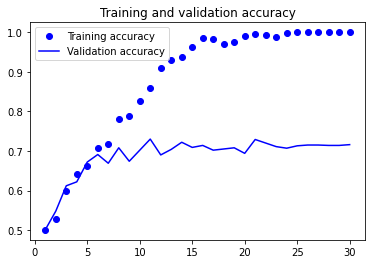

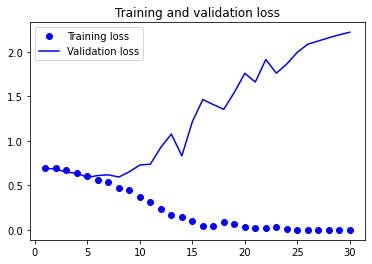

In [14]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Análise dos resultados dos gráficos acima
Os gráficos são característicos de overfitting. A precisão do treinamento aumenta linearmente ao longo do tempo, até atingir quase 100%, enquanto a precisão da validação atinge um pico de 72%.<p>
A perda de validação atinge seu mínimo após apenas dez épocas e então para, enquanto a perda de treinamento continua diminuindo linearmente à medida que o treinamento prossegue.<p>
Vamos verificar a precisão do teste. Vamos recarregar o modelo do arquivo salvo para avaliar como era antes de começar a overfitting.

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 29s 447ms/step - loss: 0.6103 - accuracy: 0.6690
Test accuracy: 0.669


Obtivemos uma acurácia de 67%. (Devido à aleatoriedade das inicializações da rede neural, você pode obter números dentro de um ponto percentual disso.)<p>
Como temos relativamente poucas amostras de treinamento (2.000), o overfitting será a preocupação número um.<p>
Uma série de técnicas que podem ajudar a mitigar o overfitting, como dropout por exemplo.<p>
Agora será trabalhada uma nova técnica, específica para visão computacional e usado quase universalmente ao processar imagens com modelos de aprendizado profundo: o **data augmentation ou seja, aumento de dados.**

# Usando data augmentation

O overfitting é causado por ter muito poucas amostras para aprender, tornando difícil para treinar um modelo que possa generalizar para novos dados.<p>
O aumento de dados adota a abordagem de gerar mais dados de treinamento
de amostras de treinamento existentes, aumentando as amostras por meio de um número de transformações que produzem imagens de aparência crível. O objetivo é que, na hora do treino, o modelo nunca verá exatamente a mesma imagem duas vezes. Isso ajuda a expor o modelo para mais aspectos dos dados para que possa generalizar melhor.<p>
No Keras, isso pode ser feito adicionando várias camadas de aumento de dados na
início do seu modelo. Vamos começar com um exemplo: o seguinte modelo Sequencial
encadeia várias transformações de imagem aleatórias. Em nosso modelo, incluiríamos antes da **Rescaling layer** lá nas camadas da Rede Neural Convolucional.

#Data augmentation para adicionar mais imagens ao modelo

In [16]:
data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)

Essas são apenas algumas das camadas disponíveis (para saber mais, consulte a documentação do Keras).

**RandomFlip("horizontal")** — Aplica inversão horizontal a 50%
as imagens que passam por ela<p>
**RandomRotation(0.1)** — Gira as imagens de entrada por um valor aleatório no intervalo[–10%, +10%] (estas são frações de um círculo completo - em graus, o intervalo seria [–36 graus, +36 graus])<p>
**RandomZoom(0.2)**—Aproxima ou diminui a imagem por um fator aleatório no
intervalo [-20%, +20%]


# Exibindo algumas imagens de treinamento aumentadas com data augmentation

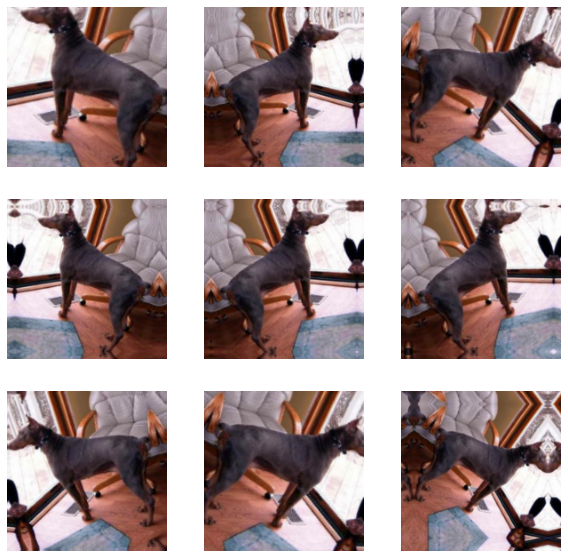

In [17]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(1): 
 for i in range(9):
     augmented_images = data_augmentation(images) # Aplica o estágio de aumento de dados ao lote de imagens
     ax = plt.subplot(3, 3, i + 1) #Plot das imagens (3 linhas por 3 colunas)
     plt.imshow(augmented_images[0].numpy().astype("uint8"))  # Exibe a primeira imagem no lote de saída. Para cada uma das nove iterações, este é um aumento diferente da mesma imagem
     plt.axis("off")

Se treinarmos um novo modelo usando essa configuração de aumento de dados, o modelo nunca ver a mesma entrada duas vezes. Mas as entradas que ele vê ainda estão fortemente correlacionadas porque eles vêm de um pequeno número de imagens originais - não podemos produzir novas em formação; só podemos remixar informações existentes. Como tal, isso pode não ser suficiente para se livrar completamente do overfitting. Para combater ainda mais o overfitting, também adicionaremos uma camada Dropout  ao  modelo logo antes do classificador densamente conectado.<p>
Um detalhe a saber sobre camadas de aumento de imagem aleatória:<p>
Apenas como Dropout, eles ficam inativos durante a inferência (quando chamamos predict() ou evaluate().<p>
Durante a avaliação, o modelo se comportará da mesma forma que quando não incluía aumento de dados.

# Definindo novo modelo com dropout e data augmentation

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])

Vamos treinar o modelo usando data augmentation e dropout. Como esperamos que o ajuste excessivo (overfitting) ocorra muito mais tarde durante o treinamento, treinaremos três vezes mais épocas - ou seja 100 épocas

# Novo treino

In [21]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch_with_augmentation.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_dataset,
 epochs=100,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 114s 2s/step - loss: 0.6974 - accuracy: 0.5030 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 112s 2s/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 112s 2s/step - loss: 0.6937 - accuracy: 0.5065 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 112s 2s/step - loss: 0.6939 - accuracy: 0.5130 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 112s 2s/step - loss: 0.6937 - accuracy: 0.5050 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 112s 2s/step - loss: 0.6935 - accuracy: 0.5020 - val_loss: 0.6930 - val_accuracy: 0.5010
Epoch 7/100
63/63 [==============================] - 112s 2s/step - loss: 0.6943 - accuracy: 0.5130 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 

# Plotar os resultados novamente

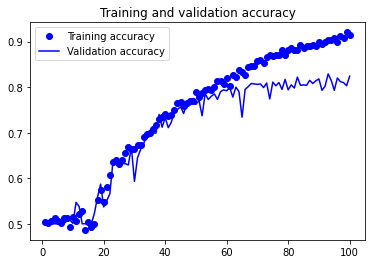

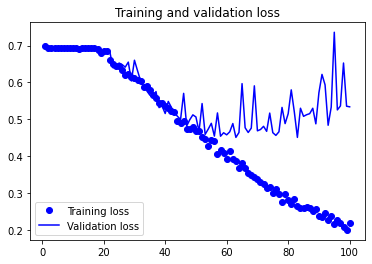

In [22]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Graças ao aumento de dados e dropout,  o overfitting começou muito mais tarde, por volta das épocas 60-70 (em comparação com a época 10 do modelo original). A precisão da validação termina consistentemente na faixa de 80 a 85%— uma grande melhoria em relação à primeira tentativa

# Avaliando o modelo no conjunto de teste (imagens novas nunca "vistas" pelo modelo)

In [23]:
test_model = keras.models.load_model(
 "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 28s 437ms/step - loss: 0.4670 - accuracy: 0.8160
Test accuracy: 0.816


Foi obtida uma precisão de teste de 82%. Já Melhorou! Se estiver usando o Colab, certifique-se de baixar o arquivo salvo (convnet_from_scratch_with_augmentation.keras),
que será usado  para alguns experimentos.<p>
Ao ajustar ainda mais a configuração do modelo (como o número de filtros por
camada de convolução, ou o número de camadas no modelo), podemos obter uma
precisão ainda melhor, provavelmente até 90%. Mas seria difícil ir mais alto
apenas treinando o modelo  do zero, porque temos tão poucos dados para trabalhar. Como próximo passo para melhorar a precisão neste problema, será usado um modelo pré-treinado a **VGG16**.

**Referências:**<p>

Livro: Deep Learning With Python [François Chollet, 2021]- Segunda edição<p>

Capítulo 5 - Fundamentals of machine learning<p>

Capítulo 8 - Introduction to Deep Learning for computer vision<p>

Dataset: www.kaggle.com/c/dogs-vs-cats/data